<a href="https://colab.research.google.com/github/carlosbarrone/public_notebooks/blob/main/unsupervised_text_classification_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Product Reviews - Topic Modelling

In [ ]:
!pip install -q -r ./requirements.txt

In [ ]:
import gzip
import json
import re
import nltk
import spacy
import logging
import warnings
import pyLDAvis

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from collections import defaultdict
from datetime import date
from tqdm import tqdm
from tmtoolkit.corpus import Corpus, print_summary, lemmatize, to_lowercase, remove_punctuation, corpus_add_tabular, dtm, doc_texts
from tmtoolkit.corpus import filter_clean_tokens, filter_for_pos, remove_common_tokens, remove_uncommon_tokens, remove_tokens
from tmtoolkit.utils import disable_logging
from tmtoolkit.topicmod.model_io import print_ldamodel_topic_words
from tmtoolkit.topicmod.tm_lda import compute_models_parallel
from tmtoolkit.topicmod.visualize import parameters_for_ldavis
from tmtoolkit.topicmod import tm_lda
from tmtoolkit.topicmod.evaluate import results_by_parameter
from tmtoolkit.topicmod.visualize import plot_eval_results
from tmtoolkit.bow.bow_stats import doc_lengths
from tmtoolkit.topicmod.model_stats import generate_topic_labels_from_top_words
from tmtoolkit.topicmod.model_io import ldamodel_top_doc_topics

from textblob import TextBlob

sp = spacy.load('en_core_web_sm')
nltk.download('stopwords')
stopwords = [re.sub('[^A-Za-z]+', '', w) for w in nltk.corpus.stopwords.words('english')]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/carlos_barron/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Libraries & Imports
- Machine Learning Libraries (Pandas, Numpy, Matplotlib, NLTK)
- TMToolkit
- TextBlob (For sentiment analysis)
- Spacy for TMToolkit compatibility

### Folder structure of the project

In order not to iterate the project more simply I will use this folder structure, this will build CSV files only for the first time, then it will load the resulting preprocessed CSV files.

I will also use a requirements.txt file to install all dependencies.

    .
    └── Root/
        ├── .venv
        ├── amz_prd_rv_topic_modelling.ipynb
        ├── data/
        │   ├── csv/ (saved CSV for post loading)
        |   |   ├── product_metadata_clothing_shoes_and_jewelry.csv (Amazon reviews converted to CSV)
        |   |   ├── reviews_clothing_shoes_and_jewelry.csv (Amazon products converted to CSV)
        |   |   ├── nike_reviews.csv (All Nike products reviews)
        |   |   ├── nike_reviews_subset.csv (Nike products filtered by category=shoes, negative sentiment, top 3000 selling rank)
        │   └── gzip/
        │       ├── product_metadata_clothing_shoes_and_jewelry.jsonl.gz
        │       └── reviews_clothing_shoes_and_jewelry.json
        └── requirements.txt

In [ ]:
GZIP_FOLDER_PATH = './data/gzip'
CSV_FOLDER_PATH = './data/csv'
PRODUCT_METADATA_FILE_PATH = f'{GZIP_FOLDER_PATH}/product_metadata_clothing_shoes_and_jewelry.jsonl.gz'
REVIEWS_FILE_PATH = f'{GZIP_FOLDER_PATH}/reviews_clothing_shoes_and_jewelry.json.gz'
PREPROCESSED_PRODUCT_METADATA_FILE_PATH = f'{CSV_FOLDER_PATH}/product_metadata_clothing_shoes_and_jewelry.csv'
PREPROCESSED_REVIEWS_FILE_PATH = f'{CSV_FOLDER_PATH}/reviews_clothing_shoes_and_jewelry.csv'
ALL_NIKE_REVIEWS_CSV = f'{CSV_FOLDER_PATH}/nike_reviews.csv'
NIKE_REVIEWS_SUBSET_CSV = f'{CSV_FOLDER_PATH}/nike_reviews_subset.csv'

### Project constants

In order to have visual information about the progress of some of the processes we know that:

In [ ]:
TOTAL_REVIEWS = 5748920
TOTAL_PRODUCTS = 1503384

### Project functions and classes

In [ ]:
all_categories  = defaultdict(lambda: 0)

def get_negative_texts(texts):
    return [text for text in texts if TextBlob(text).sentiment.polarity < 0.5]

def build_corpus(texts, lang="en"):
    corpus = Corpus({ i:r for i, r in enumerate(texts) }, language=lang)
    lemmatize(corpus)
    to_lowercase(corpus)
    remove_punctuation(corpus)
    filter_clean_tokens(corpus, remove_stopwords=True, remove_empty=True, remove_numbers=True, remove_shorter_than=2)
    return corpus

def sample_gzip_jsonl_file(path: str)->dict:
    d = None
    with gzip.open(path) as file:
        d = file.readline()
        return d

def process_categories(categories: list[list[str]])->list[str]:
  categories = list(set([re.sub('[^A-Za-z0-9 ]+','',w.lower().strip()) for category in categories for w in category]))
  for c in categories:
    all_categories[c] += 1
  return ' '.join(' '.join(categories).split())

class Review:
  def __init__(self, props: dict, merge_summary: bool = True, clean_text: bool = True, remove_stopwords: bool = True, remove_repeated_words: bool = True) -> None:
    try:
      self.reviewer_id = props.get('reviewerID')
      self.asin = props.get('asin')
      self.reviewer_name = props.get('reviewerName')
      self.helpful = props.get('helpful')
      self.overall = props.get('overall')
      self.unix_review_time = props.get('unixReviewTime')
      self.review_id = str(self.reviewer_id) + '_' + str(self.asin) + '_' + str(self.unix_review_time)
      self.review_time = date.fromtimestamp(self.unix_review_time) if self.unix_review_time else None
      if merge_summary and clean_text:
        self.review = self.clean(str(props.get('summary')) + ' '+ str(props.get('reviewText')))
      else:
        if merge_summary:
          self.review = str(props.get('summary')) + ' '+ str(props.get('reviewText'))
        if clean_text:
          self.review = self.clean(props.get('reviewText'))
      self.review = ' '.join(list(set([w for w in self.review.split() if w not in stopwords]))) if remove_repeated_words else ' '.join([w for w in self.review.split() if w not in stopwords])
      self.review_raw = str(props.get('summary')) + ' ' + str(props.get('reviewText')) if merge_summary else str(props.get('reviewText'))
      self.talks_about_nike = self.check_contains_nike()
    except Exception as e:
      print(e)

  def clean(self, text: str, remove_special_chars: bool = True, remove_numbers: bool = True, set_lowercase: bool = True):
    try:
      text = text.strip()
      text = re.sub('[^A-Za-z0-9 ]+', '', text) if remove_special_chars else text
      text = re.sub('[0-9]+', '', text) if remove_numbers else text
      text = text.lower() if set_lowercase else text
      return ' '.join(text.split())
    except Exception as e:
      print(e)

  def check_contains_nike(self)->bool:
    try:
      pattern = re.compile(r'nike',re.IGNORECASE)
      return pattern.search(self.review) != None
    except Exception as e:
      print(e)

  def to_dict(self):
    return self.__dict__

class Product_Metadata:
  def __init__(self, props: dict) -> None:
    cat = process_categories(props.get('categories'))
    sr = props.get('salesRank')
    try:
      if sr:
        ranking_categories = list(props['salesRank'].keys())
        self.primary_category = re.sub('[^A-Za-z0-9 ]','',list(props['salesRank'].keys())[0])
        self.sales_rank = props['salesRank'][list(props['salesRank'].keys())[0]]
      else:
        self.primary_category = None
        self.sales_rank = None
      self.asin = props.get('asin')
      self.brand = props.get('brand') if props.get('brand') else 'NA'
      self.title = props.get('title')
      self.price = props.get('price')
      self.categories = cat

    except Exception as e:
      print(e)

  def to_dict(self):
    return self.__dict__

def build_reviews_df(load_path: str, save_path: str = False)->pd.DataFrame:
  reviews = []
  with gzip.open(load_path, 'r') as file:
    print('Loading data...')
    for r in tqdm(file, total=TOTAL_REVIEWS):
      try:
          review = Review(json.loads(r)).to_dict()
          reviews.append(review)
      except KeyboardInterrupt as ki:
        return pd.DataFrame(reviews)
      except Exception as e:
        print(e)
    print('Loading data done.')
    print('Building Data Frame...')
    final_df: pd.DataFrame = pd.DataFrame(reviews)
    print('Building Data Frame done.')
    if save_path:
      print('Writing CSV to drive...')
      try:
        final_df.to_csv(save_path, index=False)
        print('Data Frame written to file.')
      except Exception as e:
        print('build_reviews_df:ERROR_WRITING_FILE:',e)
    del reviews
    return final_df

def build_product_metadata_df(load_path: str, save_path: str = False)->pd.DataFrame:
  products = []
  with gzip.open(load_path, 'r') as file:
    print('Loading data...')
    for  p in tqdm(file, total=TOTAL_PRODUCTS):
      try:
          product = Product_Metadata(json.loads(p)).to_dict()
          products.append(product)
      except KeyboardInterrupt as ki:
        return pd.DataFrame(products)
      except Exception as e:
        print(e,type(e))
    print('Loading data done.')
    print('Building Data Frame...')
    final_df: pd.DataFrame = pd.DataFrame(products)
    print('Building Data Frame done.')
    if save_path:
      print('Writing CSV to drive...')
      try:
        final_df.to_csv(save_path, index=False)
        print('Data Frame written to file.')
      except Exception as e:
        print('build_reviews_df:ERROR_WRITING_FILE:',e)
    del products
    return final_df

def tweak_products_df(df:pd.DataFrame)->pd.DataFrame:
  df['asin']= df['asin'].astype(str)
  return df.astype({
    'primary_category': 'category',
    'sales_rank': 'float64',
    'asin': 'object',
    'brand': 'object',
    'title':'object',
    'price': 'float64',
    'categories': 'object'
  })

def tweak_reviews_df(df:pd.DataFrame)->pd.DataFrame:
  df['asin']= df['asin'].astype(str)
  return df.astype({
    'reviewer_id': 'category',
    'asin': 'object',
    'reviewer_name': 'object',
    'helpful': 'object',
    'review':'object',
    'review_raw':'object',
    'talks_about_nike': 'bool',
    'overall': 'float32',
    'unix_review_time': 'int64',
    'review_time':'object'
  })

def unique_values(data, key):
    return list(set([d[key] for d in data if key in d]))

### Exploratory Data Analysis (EDA) and Preprocessing

The files are in JSONL format, meaning that there is one dictionary per line in the file. In order to merge all of the data into a single place we need to go through the file line by line and collect the data.

Let's have a quick look into the first line of each:

In [ ]:
sample_gzip_jsonl_file(PRODUCT_METADATA_FILE_PATH)

b'{"asin": "0000037214", "related": {"also_viewed": ["B00JO8II76", "B00DGN4R1Q", "B00E1YRI4C"]}, "title": "Purple Sequin Tiny Dancer Tutu Ballet Dance Fairy Princess Costume Accessory", "price": 6.99, "salesRank": {"Clothing": 1233557}, "imUrl": "http://ecx.images-amazon.com/images/I/31mCncNuAZL.jpg", "brand": "Big Dreams", "categories": [["Clothing, Shoes & Jewelry", "Girls"], ["Clothing, Shoes & Jewelry", "Novelty, Costumes & More", "Costumes & Accessories", "More Accessories", "Kids & Baby"]]}\n'

In [ ]:
sample_gzip_jsonl_file(REVIEWS_FILE_PATH)

b'{"reviewerID": "A2XVJBSRI3SWDI", "asin": "0000031887", "reviewerName": "abigail", "helpful": [0, 0], "reviewText": "Perfect red tutu for the price. I baught it as part of my daughters Halloween costume and it looked great on her.", "overall": 5.0, "summary": "Nice tutu", "unixReviewTime": 1383523200, "reviewTime": "11 4, 2013"}\n'

Now, let's process our datasets and build pandas dataframes out of them. In the "Project classes and functions" sections you can find the following:
1. The Product_Metadata class: it's a simple class that collects the information from our product metadata dataset
2. The Review class: Another simple class that collects the information from our reviews dataset
3. A function to build the product metadata dataframe which leverages another function to proccess categories.
4. A function to build the reviews dataframe.
5. Two dataframe tweaker functions to setup the datatypes

These functions and classes will collect the data from our gzipped files and convert them into dataframes, then save them as csv's for later reuse. Simple logic, to switch on create/read provided.

In [ ]:
try:
  print('Reading from CSV file...')
  reviews_df = pd.read_csv(PREPROCESSED_REVIEWS_FILE_PATH)
except FileNotFoundError as e:
  print('File does not exist, building reviews Data Frame...')
  reviews_df = build_reviews_df(REVIEWS_FILE_PATH, PREPROCESSED_REVIEWS_FILE_PATH)
except Exception as e:
  print(e,type(e))

Reading from CSV file...
File does not exist, building reviews Data Frame...
Loading data...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5748920/5748920 [07:10<00:00, 13344.69it/s]


Loading data done.
Building Data Frame...
Building Data Frame done.
Writing CSV to drive...
Data Frame written to file.


In [ ]:
try:
  print('Reading from CSV file...')
  products_df = pd.read_csv(PREPROCESSED_PRODUCT_METADATA_FILE_PATH)
except FileNotFoundError as e:
  print('File does not exist, building reviews Data Frame...')
  products_df = build_product_metadata_df(PRODUCT_METADATA_FILE_PATH,PREPROCESSED_PRODUCT_METADATA_FILE_PATH)
except Exception as e:
  print(e,type(e))

Reading from CSV file...
File does not exist, building reviews Data Frame...
Loading data...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1503384/1503384 [00:26<00:00, 57496.50it/s]


Loading data done.
Building Data Frame...
Building Data Frame done.
Writing CSV to drive...
Data Frame written to file.


Below samples of the resulting dataframes

In [ ]:
reviews_df = tweak_reviews_df(reviews_df)
reviews_df.sample(3)

,reviewer_id,asin,reviewer_name,helpful,overall,unix_review_time,review_id,review_time,review,review_raw,talks_about_nike
1066518,A3QI17FCTFEUYQ,B001B10188,Cows,"[0, 0]",5.0,1368230400,A3QI17FCTFEUYQ_B001B10188_1368230400,2013-05-11,project judges liked simple part yet display u...,Very Nice simple yet very nice looking. I used...,False
3414603,A0203569QEFAU01BTAMM,B006MK43TG,Ginger,"[2, 3]",4.0,1357257600,A0203569QEFAU01BTAMM_B006MK43TG_1357257600,2013-01-04,liked thing arrived product suppose boost plea...,It's awesome! I'm really pleased with this ite...,False
393174,A2CRM0EUORW345,B000G1JM02,A. Lang,"[0, 0]",3.0,1398124800,A2CRM0EUORW345_B000G1JM02_1398124800,2014-04-22,preschoolers crocs good time wearing wait wear...,"Good price, but way too big. My preschooler's ...",False


In [ ]:
products_df = tweak_products_df(products_df)
products_df.sample(3)

,primary_category,sales_rank,asin,brand,title,price,categories
1299248,Clothing,58766.0,B00E8FZPSU,NA,David's Bridal Women's Chiffon Heart Short Bri...,99.99,special occasion dresses clothing shoes jewelr...
549221,Shoes,319.0,B005DO4KWC,NA,Dansko Women's Sophie Sandal,120.00,clothing shoes jewelry shoes sandals shoes acc...
1030360,Shoes,284.0,B00AQEN2OG,NA,Stride Rite Ariana Sneaker (Toddler/Little Kid),NaN,clothing shoes jewelry shoes boys stride rite ...


We are interested in Nike Products, let's see how many Nike products we have in our dataset, where Nike is mentioned in any of the categories:

In [ ]:
nike_products = products_df[products_df.categories.str.contains('nike')]
len(nike_products)

8327

Since we wan't Nike reviews we can join the reviews and nike products dataframes together in a single dataframe by the asin column, this will give us the nike reviews only.

In [ ]:
nike_reviews = reviews_df.merge(
    nike_products,
    on='asin',
    how='inner'
)
print(len(nike_reviews))
nike_reviews.sample(3)

21570


,reviewer_id,asin,reviewer_name,helpful,overall,unix_review_time,review_id,review_time,review,review_raw,talks_about_nike,primary_category,sales_rank,brand,title,price,categories
4242,A22YYMMZHHZNO5,B002J77ASC,Pam J,"[1, 3]",5.0,1330992000,A22YYMMZHHZNO5_B002J77ASC_1330992000,2012-03-06,might enjoy around choice comfort long slide c...,"Comfort Slide I enjoy these slide on, very com...",False,Shoes,2560.0,NA,Nike Women's Comfort Slide,NaN,clothing shoes jewelry shoes n sandals women nike
16685,A1ZCJBDNMZZGYN,B009L2GI7C,Rodney A. Lee,"[1, 1]",5.0,1366070400,A1ZCJBDNMZZGYN_B009L2GI7C_1366070400,2013-04-16,found cool classics shoes looks comfort severa...,Cool Shoes I love the classic looks and comfor...,True,Shoes,58146.0,NA,Nike Air Force 1 dark grey white Sneaker Shoes...,NaN,athletic clothing shoes jewelry shoes n men ba...
21107,A2ERILY651SRQ9,B00HDRMWAY,tyron thomas,"[0, 0]",5.0,1395878400,A2ERILY651SRQ9_B00HDRMWAY_1395878400,2014-03-27,great need stuff shoes get hire ups smarter lo...,GREAT I love these shoes how ever UPS need to ...,False,Shoes,116282.0,NA,Nike Air Force 1 '07 Penny Men Sneaker White/B...,NaN,clothing shoes jewelry shoes n fashion sneaker...


As an additional piece of information I will also add the sentiment polarity to the data frame.

In [ ]:
nike_reviews['sentiment_polarity'] = nike_reviews.apply(lambda df: TextBlob(df.review).sentiment.polarity, axis=1)
nike_reviews['is_negative_review'] = nike_reviews.apply(lambda df: TextBlob(df.review).sentiment.polarity < 0, axis=1)
nike_reviews.sample(3)

,reviewer_id,asin,reviewer_name,helpful,overall,unix_review_time,review_id,review_time,review,review_raw,talks_about_nike,primary_category,sales_rank,brand,title,price,categories,sentiment_polarity,is_negative_review
20044,A3NDIR4HRLUJCS,B00DYBUQ9M,"DW978 ""Dana""","[0, 0]",4.0,1395446400,A3NDIR4HRLUJCS_B00DYBUQ9M_1395446400,2014-03-22,best may choice favorite feet look however fla...,Nice Shoe This is my favorite look of the FREE...,False,Shoes,401383.0,NA,Nike Free Run 4.0 V LAW Running Shoes. Color: ...,NaN,athletic clothing shoes jewelry shoes n women ...,0.383929,False
14605,A1GNKKVTHX33UL,B007SZVWSO,txbest1980,"[0, 0]",5.0,1379548800,A1GNKKVTHX33UL_B007SZVWSO_1379548800,2013-09-19,gym bag pockets never good jordan years huge m...,Nice Big Bag I have ordered a few Jordan bags ...,False,Clothing,406815.0,NA,Nike Jordan All Day Duffel (Cool Grey/Black),NaN,clothing shoes jewelry luggage travel gear n l...,0.150000,False
3861,A2JWIULXAAEVU,B002CCKG62,Maria,"[6, 9]",5.0,1343347200,A2JWIULXAAEVU_B002CCKG62_1343347200,2012-07-27,everyday worth last enjoyment years plays pair...,Hard to find My son plays basketball everyday....,False,Shoes,84522.0,NA,Nike Air Jordan 12 Retro XII Black/Blue Mens B...,NaN,clothing shoes jewelry shoes n fashion sneaker...,-0.098333,True


And save the result to disk to begin our final preprocessing:

In [ ]:
nike_reviews.to_csv(ALL_NIKE_REVIEWS_CSV, index=False)

In [ ]:
nike_reviews = None
try:
    nike_reviews = pd.read_csv(ALL_NIKE_REVIEWS_CSV)
    del reviews_df
    del products_df
except FileNotFoundError as e:
    print('Run the previous cell to regenerate file.')
except NameError as e:
    print(' DFs were already deleted.')
except Exception as e:
    print(e, type(e))
nike_reviews.sample(3)

,reviewer_id,asin,reviewer_name,helpful,overall,unix_review_time,review_id,review_time,review,review_raw,talks_about_nike,primary_category,sales_rank,brand,title,price,categories,sentiment_polarity,is_negative_review
7773,A22AYWTZ9MW756,B004PSOIVA,Nomad,"[0, 0]",5.0,1404691200,A22AYWTZ9MW756_B004PSOIVA_1404691200,2014-07-07,timely stars arrived product expected five man...,"Five Stars product fit as expected, arrived in...",False,Clothing,5062.0,NaN,Nike Men's Crew Cut Moisture Management Socks ...,NaN,clothing shoes jewelry sports outdoors n cloth...,0.150000,False
7703,A146KMECZOYLKW,B004PNTDOW,Koki,"[0, 0]",5.0,1349308800,A146KMECZOYLKW_B004PNTDOW_1349308800,2012-10-04,great bought generally shoes box break wear co...,Great shoes These shoes are great right out of...,False,NaN,NaN,NaN,Nike Air Brassie Women's Golf Shoe (White/Smok...,NaN,athletic clothing shoes jewelry shoes golf n w...,0.378571,False
4152,AHMMA2MP9TGSG,B002IO9V6U,JUAN CARLOS FLORES LUNA,"[0, 0]",5.0,1399507200,AHMMA2MP9TGSG_B002IO9V6U_1399507200,2014-05-08,shoes looks like wear grass walk races far happy,some races on them By far I am very happy with...,False,Shoes,439631.0,NaN,Nike Men's NIKE AIR PEGASUS+ 26 RUNNING SHOES ...,NaN,athletic clothing shoes jewelry shoes n runnin...,0.450000,False


Below we can see:
- The review length distribution
- The distribution of positive and negative reviews (Using TextBlob Package)
- The sales rank distribution of Nike products

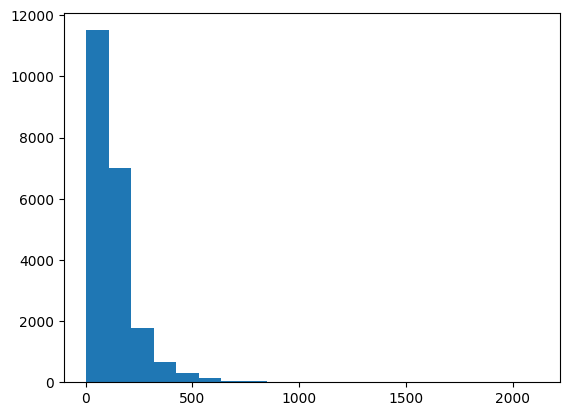

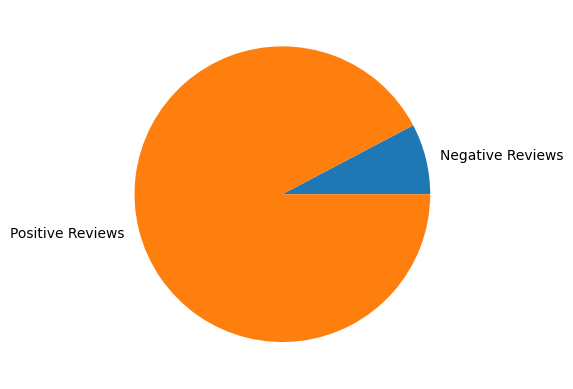

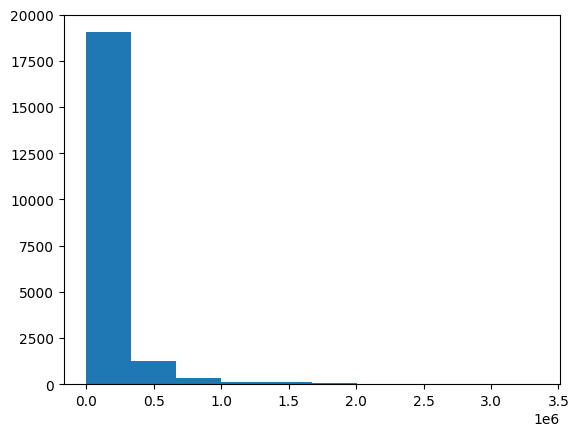

In [ ]:
plt.hist(nike_reviews.review.str.len(), bins=20)
plt.show()

plt.pie(
    [nike_reviews.is_negative_review.sum(), nike_reviews.is_negative_review.count()-nike_reviews.is_negative_review.sum()],
    labels=['Negative Reviews','Positive Reviews']
)
plt.show()

plt.hist(nike_reviews.sales_rank, bins=10)
plt.show()

## Extra Preprocessing using TMToolkit

I will further segment the reviews by the following parameters:
- Sentiment
- Sales Rank
- Category is Shoes

In [ ]:
nike_shoes_negative_top3000 = nike_reviews[(nike_reviews.is_negative_review) & (nike_reviews.sales_rank < 3000) & (nike_reviews.primary_category == 'Shoes')]
print(len(nike_shoes_negative_top3000))
nike_shoes_negative_top3000.to_csv(NIKE_REVIEWS_SUBSET_CSV, index=False)

303


In [ ]:
try:
    nike_reviews
except Exception as e:
    print(e)

In [ ]:
corpus = Corpus(spacy_instance=sp)
corpus_sm = Corpus(spacy_instance=sp)
corpus_add_tabular(corpus, files=NIKE_REVIEWS_SUBSET_CSV, id_column='review_id', text_column='review')
corpus_add_tabular(corpus_sm, files=NIKE_REVIEWS_SUBSET_CSV, id_column='review_id', text_column='review')

In [ ]:
lemmatize(corpus)
remove_tokens(corpus,['sandal','foot', 'shoe', 'nike', 'benassi', 'pair'])

lemmatize(corpus_sm)
remove_common_tokens(corpus_sm,df_threshold=0.8)
remove_uncommon_tokens(corpus_sm, df_threshold=0.01)
filter_clean_tokens(corpus_sm, remove_shorter_than=2)
filter_for_pos(corpus_sm, ('N', 'V', 'ADJ'))
remove_tokens(corpus_sm,['sandal','foot', 'shoe', 'nike', 'benassi', 'pair'])


print_summary(corpus)
print_summary(corpus_sm)

Corpus with 303 documents in English
> nike_reviews_subset-A10RDDLMCUTHVX_B001V6TJXG_1380326400 (31 tokens): high arches occurrencei star wrap integral top cha...
> nike_reviews_subset-A12SOQ5ACMUR4P_B0031DQB3S_1396051200 (10 tokens): enough need asphalt walk lot long go walk give cus...
> nike_reviews_subset-A036147939NFPC389VLK_B000G42Z2Q_1398816000 (17 tokens): something small run know order one otherwise big w...
> nike_reviews_subset-A12KM6FDTR9HRI_B0024FQIRI_1375747200 (8 tokens): expensive fine pay much seeing disappointed see co...
> nike_reviews_subset-A105C374T9A12_B002H66PEK_1385078400 (8 tokens): small one want ask granddaughter style lover actua...
> nike_reviews_subset-A143VWWW5CGG2S_B004IM1GHW_1404691200 (52 tokens): house daymy return think funny trip forget cripple...
> nike_reviews_subset-A12MFVBBWZA0G4_B004IM1GHW_1366761600 (40 tokens): sole recommend terribly ever wobble time irritate ...
> nike_reviews_subset-A13Q9XKAWRD628_B004IM1GHW_1383177600 (34 tokens): workth

## Hyperparameter Evaluation

In [ ]:
dtm_corpus, doc_labels, vocab = dtm(corpus, return_doc_labels=True, return_vocab=True)
dtm_corpus

<303x1744 sparse matrix of type '<class 'numpy.int32'>'
	with 6078 stored elements in Compressed Sparse Row format>

In [ ]:
dtm_corpus_sm, doc_labels_sm, vocab_sm = dtm(corpus_sm, return_doc_labels=True, return_vocab=True)
dtm_corpus_sm

<303x273 sparse matrix of type '<class 'numpy.int32'>'
	with 2979 stored elements in Compressed Sparse Row format>

INFO:lda:n_documents: 303
INFO:lda:vocab_size: 273
INFO:lda:n_words: 3090
INFO:lda:n_topics: 3
INFO:lda:n_iter: 1000
INFO:lda:<0> log likelihood: -21570
INFO:lda:<10> log likelihood: -18011
INFO:lda:<20> log likelihood: -17543
INFO:lda:<30> log likelihood: -17479
INFO:lda:<40> log likelihood: -17465
INFO:lda:<50> log likelihood: -17476
INFO:lda:<60> log likelihood: -17479
INFO:lda:<70> log likelihood: -17566
INFO:lda:<80> log likelihood: -17593
INFO:lda:<90> log likelihood: -17526
INFO:lda:n_documents: 303
INFO:lda:vocab_size: 273
INFO:lda:n_words: 3090
INFO:lda:n_topics: 5
INFO:lda:n_iter: 1000
INFO:lda:<100> log likelihood: -17462
INFO:lda:<110> log likelihood: -17543
INFO:lda:<120> log likelihood: -17557
INFO:lda:<0> log likelihood: -24253
INFO:lda:<130> log likelihood: -17628
INFO:lda:<10> log likelihood: -18966
INFO:lda:<140> log likelihood: -17503
INFO:lda:<20> log likelihood: -18434
INFO:lda:<30> log likelihood: -18187
INFO:lda:<150> log likelihood: -17504
INFO:lda:<40> log like

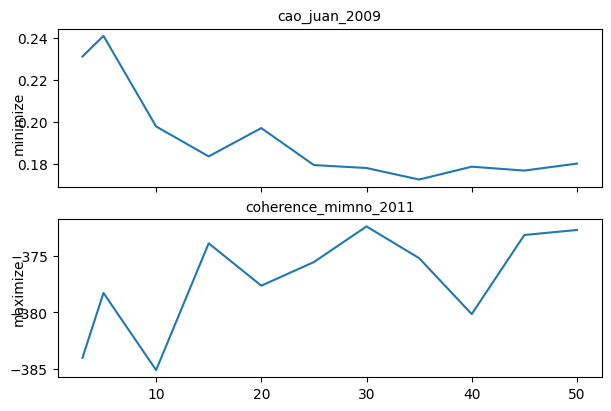

In [ ]:
fixed_params = {
    'n_iter': 1000,
    'eta': 0.1,
    'random_state': 2023
}

ks = [3]+list(range(5,55,5))
variable_params = [{
    'n_topics': k,
    'alpha': 1/k
} for k in ks]
eval_results = tm_lda.evaluate_topic_models(dtm_corpus_sm, variable_params, fixed_params)
results_by_k = results_by_parameter(eval_results, 'n_topics')
plot_eval_results(results_by_k)
plt.show()

INFO:lda:n_documents: 303
INFO:lda:vocab_size: 1744
INFO:lda:n_words: 6227
INFO:lda:n_topics: 3
INFO:lda:n_iter: 1000
INFO:lda:<0> log likelihood: -52718
INFO:lda:<10> log likelihood: -47208
INFO:lda:<20> log likelihood: -46509
INFO:lda:<30> log likelihood: -46271
INFO:lda:<40> log likelihood: -46317
INFO:lda:<50> log likelihood: -46213
INFO:lda:<60> log likelihood: -46234
INFO:lda:<70> log likelihood: -46111
INFO:lda:<80> log likelihood: -46097
INFO:lda:<90> log likelihood: -46109
INFO:lda:n_documents: 303
INFO:lda:vocab_size: 1744
INFO:lda:n_words: 6227
INFO:lda:n_topics: 20
INFO:lda:n_iter: 1000
INFO:lda:<100> log likelihood: -46132
INFO:lda:<110> log likelihood: -46075
INFO:lda:n_documents: 303
INFO:lda:vocab_size: 1744
INFO:lda:n_words: 6227
INFO:lda:n_topics: 15
INFO:lda:n_iter: 1000
INFO:lda:<120> log likelihood: -46030
INFO:lda:<130> log likelihood: -46137
INFO:lda:<0> log likelihood: -73485
INFO:lda:<0> log likelihood: -69837
INFO:lda:<140> log likelihood: -46123
INFO:lda:<10>

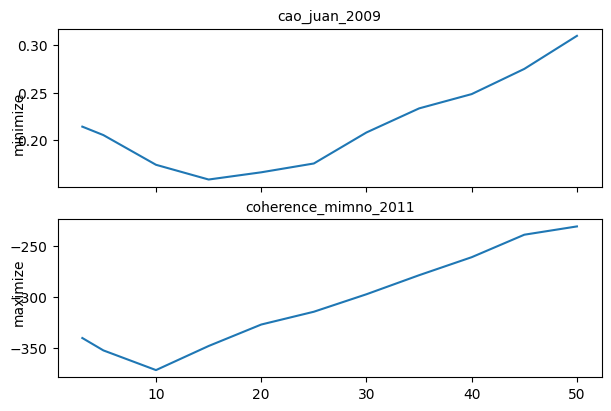

In [ ]:
eval_results = tm_lda.evaluate_topic_models(dtm_corpus, variable_params, fixed_params)
results_by_k = results_by_parameter(eval_results, 'n_topics')
plot_eval_results(results_by_k)
plt.show()

## Model

In [ ]:
# disable tmtoolkit logging for now (too much output)
disable_logging()

# suppress the "INFO" messages and warnings from lda
logger = logging.getLogger('lda')
logger.addHandler(logging.NullHandler())
logger.propagate = False

warnings.filterwarnings('ignore')

# set data to use
dtms = {
    'corpus_sm': dtm_corpus_sm
}

# and fixed hyperparameters
n_topics = 30
lda_params = {
    'n_topics': n_topics,
    'eta': 0.1, #Topic word density=high includes most of the words in topics
    'alpha': 1/n_topics, # document topic density=high alpha docs are made of more topics
    'n_iter': 1000,
    'random_state': 2023
}

models = compute_models_parallel(dtms, constant_parameters=lda_params)

INFO:lda:n_documents: 303
INFO:lda:vocab_size: 273
INFO:lda:n_words: 3090
INFO:lda:n_topics: 30
INFO:lda:n_iter: 1000
INFO:lda:<0> log likelihood: -33636
INFO:lda:<10> log likelihood: -21151
INFO:lda:<20> log likelihood: -20430
INFO:lda:<30> log likelihood: -20280
INFO:lda:<40> log likelihood: -20291
INFO:lda:<50> log likelihood: -20232
INFO:lda:<60> log likelihood: -20112
INFO:lda:<70> log likelihood: -20254
INFO:lda:<80> log likelihood: -20268
INFO:lda:<90> log likelihood: -19957
INFO:lda:<100> log likelihood: -20097
INFO:lda:<110> log likelihood: -20156
INFO:lda:<120> log likelihood: -20115
INFO:lda:<130> log likelihood: -19966
INFO:lda:<140> log likelihood: -20081
INFO:lda:<150> log likelihood: -20111
INFO:lda:<160> log likelihood: -19977
INFO:lda:<170> log likelihood: -20151
INFO:lda:<180> log likelihood: -20098
INFO:lda:<190> log likelihood: -20077
INFO:lda:<200> log likelihood: -20030
INFO:lda:<210> log likelihood: -19867
INFO:lda:<220> log likelihood: -19947
INFO:lda:<230> log 

In [ ]:
model_sm_params, model_sm = models['corpus_sm'][0]
print_ldamodel_topic_words(model_sm.topic_word_, vocab_sm, top_n=3)

topic_1
> #1. product (0.074502)
> #2. buy (0.053515)
> #3. store (0.043022)
topic_2
> #1. size (0.149292)
> #2. small (0.138394)
> #3. run (0.087541)
topic_3
> #1. sole (0.061430)
> #2. slip (0.061430)
> #3. expect (0.051360)
topic_4
> #1. fit (0.079179)
> #2. poor (0.059629)
> #3. price (0.040078)
topic_5
> #1. small (0.110878)
> #2. size (0.105623)
> #3. run (0.063584)
topic_6
> #1. small (0.078627)
> #2. year (0.045404)
> #3. want (0.045404)
topic_7
> #1. white (0.083271)
> #2. black (0.068267)
> #3. color (0.060765)
topic_8
> #1. slide (0.086817)
> #2. comfort (0.054662)
> #3. price (0.043944)
topic_9
> #1. wear (0.109049)
> #2. tight (0.093581)
> #3. strap (0.062645)
topic_10
> #1. squeak (0.064004)
> #2. wear (0.059464)
> #3. purchase (0.054925)
topic_11
> #1. buy (0.137255)
> #2. small (0.069054)
> #3. size (0.052003)
topic_12
> #1. order (0.072256)
> #2. size (0.066740)
> #3. try (0.055709)
topic_13
> #1. look (0.051132)
> #2. thin (0.042749)
> #3. year (0.034367)
topic_14
> #

In [ ]:

vocab_sm = np.array(vocab_sm)
doc_lengths_sm = doc_lengths(dtm_corpus_sm)
topic_labels = generate_topic_labels_from_top_words(
    model_sm.topic_word_,
    model_sm.doc_topic_,
    doc_lengths_sm,
    np.array(vocab_sm),
    lambda_=0.8
)
topic_labels[:15]

array(['1_product_store', '2_size_small', '3_slip_sole', '4_fit_poor',
       '5_small_size', '6_small_want', '7_white_black', '8_slide_comfort',
       '9_tight_wear', '10_squeak_purchase', '11_buy_small',
       '12_order_try', '13_thin_look', '14_buy_month', '15_feel_long'],
      dtype='<U21')

## Analysis
### Topic Description

1. product_store: Had a problem with the store (Amazon)
2. size_small: It was too small
3. slip_sole: The sole is slippery
4. fit_poor: Doesn't fit as described
5. small_size: Too small
6. small_want: Too small
7. white_black: Problem with the product color
8. slide_comfort: The slipper is not comfortable
9. tight_wear: Too tight
10. squeak_purchase: It squeaks too much
11. buy_small: Bought wrong number
12. order_try: Tried the product, and returned
13. thin_look:
14. buy_month:
15. feel_long:
16. squeak_bad:
17. uncomfortable_wear:
18. color_recommend:
19. comfortable_think:
20. customer_look:
21. give_send:
22. day_feel:
23. last_year:
24. son_love:
25. walk_comfortable:
26. time_come:
27. little_narrow:
28. people_arch:
29. review_bit:
30. wear_ill:

### Marketing & Product Insights

**Issues regarding fit, size, dimensions** (Topic 2, 5, 46, 11):
Diverse concerns about Nike products, ranging from sizing issues and discomfort to skepticism about product origin. Customers highlight problems with the fit, size, and dimensions of the products.

**Issues regarding how the product feels** (Topic 15, 13, 17, 19, 22, 25, 27, 28):
Customers express dissatisfaction with how the product feels, noting discomfort, pain, and lack of support for their feet. Some reviews mention the absence of comfort and support.

**Product look & feel** (Topic 13):
Concerns about how the product looks are raised, with some customers even finding the appearance embarrassing. The overall look and feel of the product contribute to customer dissatisfaction.

**Product noises & smell** (Topic 16, 10):
Customers report issues with funny noises or unpleasant smells from the product after use. Squeaking slippers and unpleasant odors in shoes are common complaints.

**Product was not advertised correctly, problems with Amazon shipping and Nike customer support** (Topic 1, 29):
Issues related to inaccurate product postings, shipping delays, and discrepancies with American standards are mentioned. Customers express frustration with the product not meeting advertised standards and report problems with Amazon, including slow shipping and poor customer service.


In [ ]:
doc_topic = model_sm.doc_topic_
document_classifications = ldamodel_top_doc_topics(
    doc_topic,
    doc_labels,
    top_n=3,
    topic_labels=topic_labels
)
result = document_classifications[['rank_1','rank_2','rank_3']].reset_index().rename(columns={
    'document':'review_id'
})
result.review_id = result.review_id.str.removeprefix('nike_reviews_subset-')
result.set_index('review_id')
#nike_shoes_negative_top3000.set_index('review_id')
result.merge(
    nike_shoes_negative_top3000[['review_id','review_raw']],
    on='review_id',
    how='inner'
)[['review_raw','rank_1','rank_2','rank_3',]]


,review_raw,rank_1,rank_2,rank_3
0,"Runs small Runs small, order a whole size bigg...",2_size_small (0.5028),7_white_black (0.1694),26_time_come (0.08611)
1,Benassi Sandals These were the ones my grandda...,6_small_want (0.6722),15_feel_long (0.1722),29_review_bit (0.005556)
2,Very comfy but to small To small need to get a...,5_small_size (0.8389),30_wear_ill (0.005556),29_review_bit (0.005556)
3,no tongue The shoe has no tongue. The body of...,4_fit_poor (0.6292),5_small_size (0.2542),30_wear_ill (0.004167)
4,"Have 3 pairs of these, I like them a lot but t...",9_tight_wear (0.6704),4_fit_poor (0.1148),25_walk_comfortable (0.1148)
...,...,...,...,...
298,Bad Quality very poor qualitythe sole of the ...,4_fit_poor (0.9033),30_wear_ill (0.003333),29_review_bit (0.003333)
299,Very uncomfortable small and tight shoe This ...,5_small_size (0.4396),9_tight_wear (0.2521),4_fit_poor (0.1271)
300,Three Stars There are somewhat small in the la...,25_walk_comfortable (0.7583),30_wear_ill (0.008333),14_buy_month (0.008333)
301,Wrong shoes!! I ordered these Nike sandals for...,12_order_try (0.6949),3_slip_sole (0.1564),11_buy_small (0.07949)


In [ ]:
ldavis_params = parameters_for_ldavis(
    model_sm.topic_word_,
    model_sm.doc_topic_,
    dtm_corpus_sm,
    vocab_sm
)
%matplotlib inline
vis = pyLDAvis.prepare(**ldavis_params)
pyLDAvis.enable_notebook(local=True)
pyLDAvis.display(vis)